In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brenth
import scipy.integrate as integrate

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
pi=np.pi
a=0.75
b=np.rint((1.+1.5*pi)/a) #no siempre es impar
b=b+np.mod(b+1,2)

In [3]:
def z(x, n): return (a/b)**n*np.cos(b**n*pi*x)
def w(x, n): return a**n*np.sin(b**n*pi*x)
def dw(x, n): return (a*b)**n*np.cos(b**n*pi*x)

In [31]:
def Z(x,p):
    suma=0
    for n in range(p+1):
        suma+= z(x, n)
    return -suma/pi
def W(x,p):
    suma=0
    for n in range(p+1):
        suma+= w(x, n)
    return suma
def dW(x,p):
    suma=0
    for n in range(p+1):
        suma+= dw(x, n)
    return pi*suma

In [28]:
def U(x): return 0.5*x**2+alpha*Z(x,p)
def dU(x): return x+alpha*W(x,p)
def ddU(x): return 1+alpha*dW(x,p)

def T(x): return 1-(dU(x)/g1)**2
def dT(x): return -2*dU(x)*ddU(x)/g1**2

def Ueff(x): return U(x)+T(x)/g2
def dUeff(x): return dU(x)+ dT(x)/g2
def ddUeff(x): return ddU(x)*(1-2*ddU(x)/(g2*g1**2))

def integrand(x): return dUeff(x)/T(x)
def f1(x): return dU(x)-g1
def f2(x): return dU(x)+g1

In [22]:
def root(F, x1, x2, div, it):
    X=np.linspace(x1,x2, div)
    roots=np.array([])
    for i in range(div-1):
        if F(X[i])*F(X[i+1])<=0:
            p1=X[i]
            p2=X[i+1]
            r=brenth(F, p1, p2, maxiter=it)
            roots=np.append(roots, r)
    return roots
def integral2(F, X):
    l=len(X)
    Func=np.zeros(l)
    id0=int(0.5*l)
    xmin=X[id0]
    Func[id0]=0
    for i in range(1,l):
        if i<=id0:
            x0 = X[id0-i+1]
            x1 = X[id0-i]
            Func[id0-i]=integrate.quad(F, x0, x1, maxp1=100, limlst=50)[0]
            Func[id0-i]=Func[id0-i]+Func[id0-i+1]
        else:
            x0 = X[i-1]
            x1 = X[i]
            Func[i]=integrate.quad(F, x0, x1, maxp1=100, limlst=50)[0]
            Func[i]=Func[i]+Func[i-1]
    return Func
def evol(x, h):
    e=np.random.normal(0, 1)
    y=x-h*dU(x)/g1+np.sqrt(2*T(x)*h/(g1*g2))*e
    return y

In [7]:
p = 3
Wbound= (1.-a**(p+1))/(1.-a)
Alpha = np.array([0.1, 0.9])
print(Wbound*Alpha)

[ 0.2734375  2.4609375]


## Finding g1c

In [8]:
G1c = np.array([])
for i in range(2):
    alpha = Alpha[i]
    g1 = 0.25  #finding minimum value of interest for g1
    dg1 = 1e-6
    for i in range(75):    
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a1[a1>0], a2[a2>0]])
        negative = np.concatenate([a1[a1<0], a2[a2<0]])
        xmin = max(0.999*negative)
        xmax = min(0.999*positive)
        H = root(dU, xmin, xmax, 5000, 100)
        if len(H) == 1: 
            g1 = g1 + dg1
        else:
            g1 = g1 - dg1
    g1c = g1
    G1c = np.append(G1c, g1c)
G1c

array([ 0.249925,  0.250075])

In [9]:
G1min = np.array([])
for i in range(2):
    alpha = Alpha[i]
    g1c = G1c[i]
    g1 = g1c  #finding minimum value of interest for g1
    dg1 = 0.5
    for i in range(75):    
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a1[a1>0], a2[a2>0]])
        negative = np.concatenate([a1[a1<0], a2[a2<0]])
        xmin = max(0.999*negative)
        xmax = min(0.999*positive)
        x = np.linspace(xmin,xmax, 10000)
        H = max(U(x))
        if H < 0: 
            g1 = g1 + dg1
        else:
            dg1 = 0.75*dg1
            g1 = g1 - dg1
    g1min = g1
    G1min = np.append(G1min, g1min)
G1min

array([ 0.4055041 ,  2.41710244])

### Transitions by g2 in Ueff

In [12]:
alpha=Alpha[1]
g1min=G1min[1]
g1c=G1c[1]
times=1.01
g1=times*g1min

a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
positive = np.concatenate([a2[a2>0], a1[a1>0]])
negative = np.concatenate([a2[a2<0], a1[a1<0]])
xmin = max(negative)
xmax = min(positive)
x = np.linspace(xmin,xmax, 10000)

r = root(dU, xmin, xmax, 50000, 500)
g2= 1e-7
D = ddU(r)
r = r[ D > 0] 
D = D[ D > 0]
sort = np.argsort(D)
r = r[sort]

g2c = np.array([])
for idx in range(len(r)):
    value = -1
    counter = 0
    dg2 = 1e-3
    while value < 0 :
        g2 = g2 + dg2
        value = ddUeff(r[idx])
        counter = counter + 1
    g2c = np.append(g2c, g2)

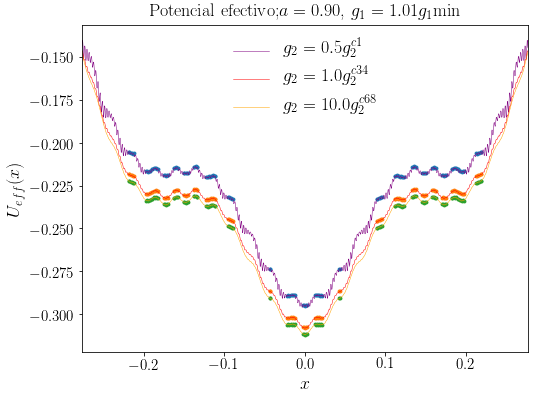

In [13]:
G2 = np.array([0.5*g2c[0], g2c[int(0.5*len(g2c))], 10*g2c[-1]])
idx = np.array([1, int(0.5*len(g2c))+1, len(g2c)+1 ], dtype=int)
legend = np.array([0.5, 1, 10])
color=['purple', 'red', 'orange']

r = root(dU, xmin, xmax, 50000, 300)
x=np.linspace(0.999*xmin,0.999*xmax, 2000)
x = np.concatenate([r,x])
x = np.sort(x)

plt.figure(figsize=(8, 6))
for i in range(3):
    g2 = G2[i]
    plt.plot(x, Ueff(x), color=color[i], alpha= 1, label=r'$g_2 = %.1f g_2^{c%d}$'%(legend[i],idx[i]), lw =0.5)
    plt.scatter(r, Ueff(r), lw=0, s=15)
    
    plt.xlim([xmin,xmax])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('$x$', fontsize=18)
    plt.ylabel(r'$U_{eff}(x)$', fontsize=18)
    plt.legend(frameon=0, loc='best', fontsize=18)
    plt.title('Potencial efectivo;$a=%.2f$,  $g_1 = %.2f g_1$min'%(alpha, times), fontsize=18)
    
plt.savefig('UeffW.png', bbox_inches='tight')
plt.show()
plt.close()

## Varios panaeles: Potencial efectivo

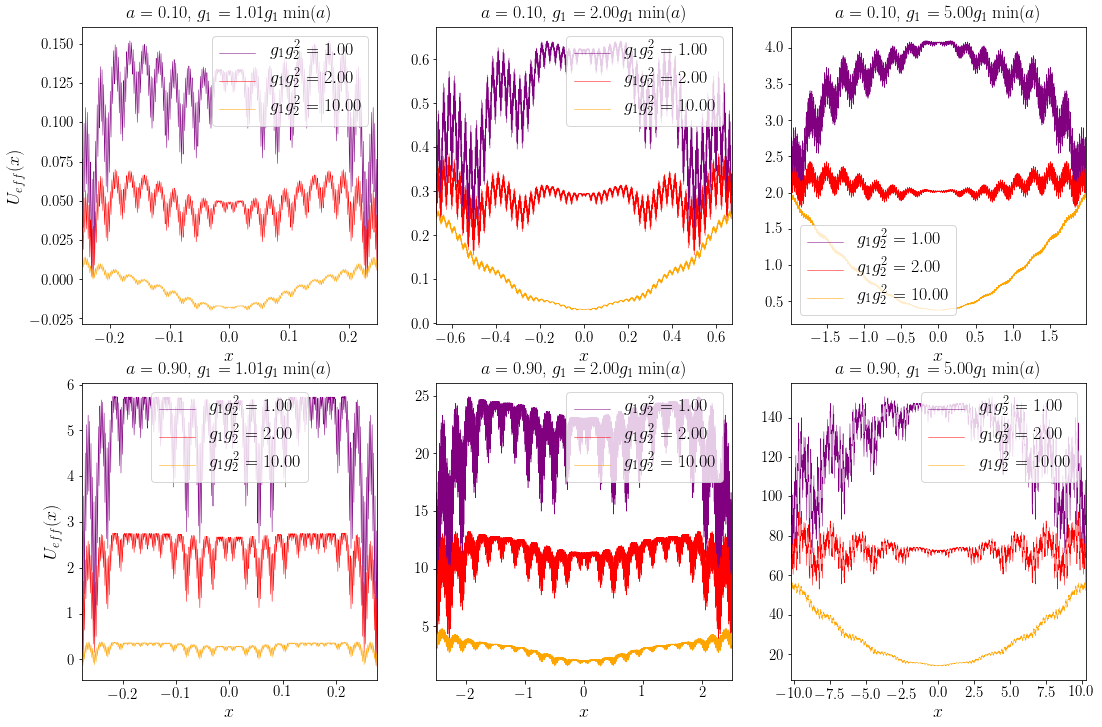

In [33]:
G1 = np.array([1.01, 2.0, 5.])
goal = np.array([1., 2., 10.0])
color=['purple', 'red', 'orange']

plt.figure(figsize=(18, 12))
for i in range(2):
    alpha=Alpha[i]
    g1min=G1min[i]
    g1c=G1c[i]
    for j in range(3):
        times=G1[j]
        g1=times*g1min
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a2[a2>0], a1[a1>0]])
        negative = np.concatenate([a2[a2<0], a1[a1<0]])
        xmin = max(negative)
        xmax = min(positive)
        
        rT = root(dT, xmin,xmax, 7000, 500)
        rU = root(dU, xmin, xmax, 7000, 500)
        x = np.linspace(xmin,xmax, 100)
        x = np.concatenate([x,rT,rU])
        x = np.sort(x)
        
        plt.subplot(2, 3, 3*i+j+1)
        for k in range(3):
            g2 = goal[k]/g1**2
            plt.plot(x, Ueff(x), color=color[k],label=r'$g_1 g_2^2=%.2f$'%goal[k], alpha= 1, lw =0.5)
        plt.xlim([xmin,xmax])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel('$x$', fontsize=18)
        plt.title(r'$a=%.2f$, $g_1 =%.2f g_1\min(a)$'%(alpha, times), fontsize=18)
        if j==0: plt.ylabel(r'$U_{eff}(x)$', fontsize=18)
        plt.legend(frameon=1, loc='best', fontsize=18)
plt.savefig('UeffW2.png', bbox_inches='tight')
plt.show()
plt.close()

## Varios Paneles: Probability

C:\Users\hp\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


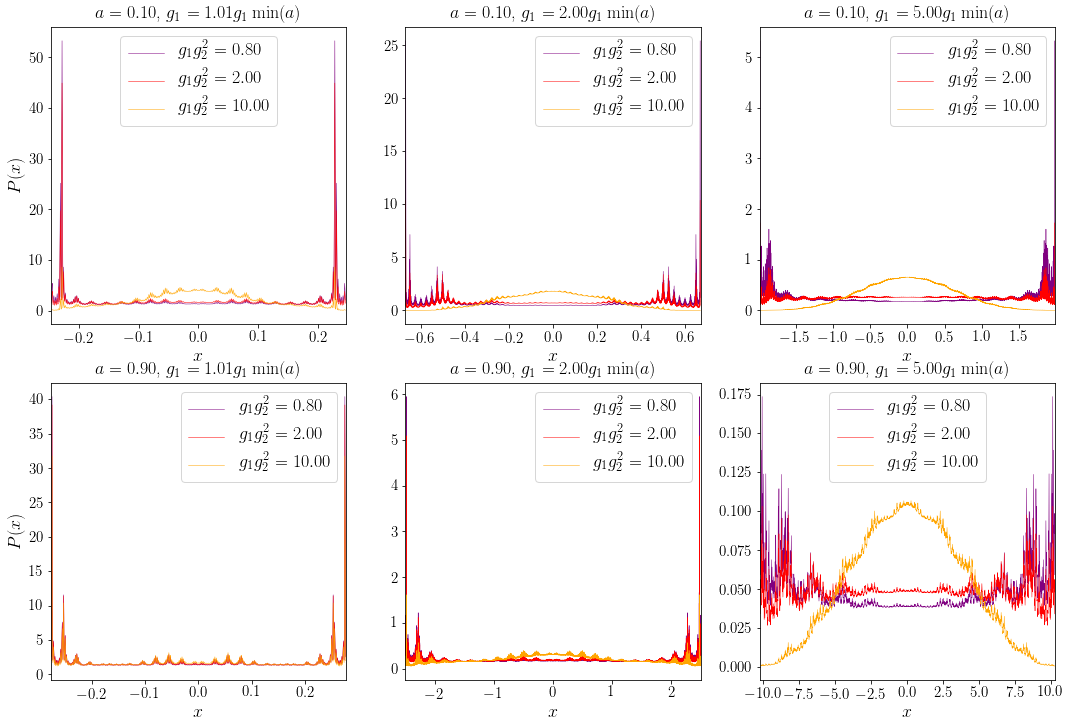

In [35]:
G1 = np.array([1.01, 2., 5.])
goal = np.array([0.8, 2., 10.])
color=['purple', 'red', 'orange']

plt.figure(figsize=(18, 12))
for i in range(2):
    alpha=Alpha[i]
    g1min=G1min[i]
    g1c=G1c[i]
    for j in range(3):
        times=G1[j]
        g1=times*g1min
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a2[a2>0], a1[a1>0]])
        negative = np.concatenate([a2[a2<0], a1[a1<0]])
        xmin = max(negative)
        xmax = min(positive)
        
        rT = root(dT, xmin,xmax, 7000, 500)
        rU = root(dU, xmin, xmax, 7000, 500)
        x = np.linspace(0.99*xmin,0.99*xmax, 100)
        x = np.concatenate([x,rT,rU])
        x = np.sort(x)
        
        plt.subplot(2, 3, 3*i+j+1)
        for k in range(3):
            g2 = goal[k]/g1**2
            inte=integral2(integrand, x)
            inte=-g2*inte
            prob=np.exp(inte)
            prob[prob==np.nan]=0
            Part=np.trapz(prob, x)
            plt.plot(x, prob/Part, color=color[k],label=r'$g_1 g_2^2=%.2f$'%goal[k], alpha= 1, lw =0.5)
        plt.xlim([xmin,xmax])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel('$x$', fontsize=18)
        plt.title(r'$a=%.2f$, $g_1 =%.2f g_1\min(a)$'%(alpha, times), fontsize=18)
        if j==0: plt.ylabel(r'$P(x)$', fontsize=18)
        plt.legend(frameon=1, loc='best', fontsize=18)
        
plt.savefig('PW2.png', bbox_inches='tight')
plt.show()
plt.close()